# Radio Modulation with FINN - Notebook #5 of 5

## FPGA setup 
**NOTE**: This notebook is meant to be run on the FPGA. After running the previous notebook, this notebook should be copied to the output directory along with the bitfile and driver files.

Make sure you have setup the FPGA with the PYNQ os correctly installed. 

To copy this notebook from you HOST machine to the FPGA and run ***on the fpga*** (substitute IP with the IP of the FPGA device)
1. `scp -r deploy xilinx@IP:/home/xilinx`
2. `ssh -L 8888:localhost:8888 xilinx@IP`
3. `sudo -E jupyter notebook --port 8888` 
4. Click the URL generated by jupyter notebook to enter jupyter and select this script. 

## Overview

This notebook walks you through how you can run benchmark and verification on the FPGA based on the bitstream and driver generated by FINN.

Overview of the generated files:
- `driver.py`: Description of the FINN-generated accelerator, including the input/output shapes and datatype.<br><br>
- `driver_base.py`: A class designed for FINN dataflow accelerator. This includes many functions such as instantiating the accelerator, running benchmark on an empty input, setting batchsize, executing inputs, ...<br><br>
- `validate.py`: An example validation python script to test run image regconition CNN accelerator. This `validate.py` file is irrelevant to our project, but it gives us a good example on how to instantiate and run validation on accelerator. Instead, we will use this notebook as a replacement for running benchmark and validation.<br><br>
- `[model_name].bit`: The generated Bitfile from synthesis depending on the target platform.<br><br>
- `[model_name].hwh`: The generated Hardware Handoff File<br><br>

### **TODO**: more documentation on data preprocesssing. Though since our case is special, where the input is already quantized to 8 bits. We may be able to remove it. However, incase we want to quantize the model down to 4bits, then we need the preprocessing back.

# Initialize the accelerator

The accelerator is Neural Network, but FPGA-ified! Specifically, the accelerator is simply a python wrapper around the bitstream we generated in the previous steps. This allows use to then treat the accelerator object as our model to achieve high performancer (higher than cpu) modulation classification by using the FPGA design! 

### Remember to install the following dependencies:

In [1]:
# ! apt-get update -y
# ! apt-get install libhdf5-dev -y
# ! pip3 install versioned-hdf5

In [1]:
!export XILINX_XRT=/usr

from finn_examples import models
# Note: the RadioML example is only available on the ZCU104 at the moment
import pynq
from pynq import PL
from driver import io_shape_dict
from driver_base import FINNExampleOverlay
import numpy as np
import math
import pickle
import os
import h5py
from pathlib import Path

PL.reset() #Ensure pynq clear cached hwh

In [2]:
accel=  FINNExampleOverlay(
        bitfile_name="./finn-accel.bit",#change this to your bitfile name
        platform="zynq-iodma",
        io_shape_dict=io_shape_dict,
        batch_size=1,
        runtime_weight_dir="runtime_weights/",
        fclk_mhz=250.0
    )   

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

Expected input shape and datatype: (1, 1024, 1, 2) INT8
Expected output shape and datatype: (1, 1) UINT8


# Load RadioML 2021 dataset

Please note that you will have to manually download the RadioML 2018 dataset and set the `dataset_dir` variable to point to its path.

In [4]:


#Change this to your dataset directory
dataset_dir = Path("./")
dataset = dataset_dir.joinpath("MatGenData.h5")
assert dataset.is_file()
print(dataset_dir)

.


In [6]:
h5_file = h5py.File(dataset,'r')
data_key='all_IQ_int8'
mod_key='all_labels'
snr_key='all_SNRs'

print("Extracting INT8 Matlab Generated Data....")
data_h5 = h5_file[data_key]

print("Get labels")
label_mod = h5_file[mod_key][:,0] # comes in one-hot encoding


print("Get SNR")
label_snr = h5_file[snr_key][:,0]

# assemble list of test set indices
# do not pre-load large dataset into memory
np.random.seed(2021)
test_indices = []
num_mods=15
num_snrs=16
for mod in range(0, num_mods): #all modulations 
    for snr_idx in range(0, num_snrs): #all SNRs 
        start_idx = num_snrs*4096*mod + 4096*snr_idx
        indices_subclass = list(range(start_idx, start_idx+4096))

        split = int(np.ceil(0.1 * 4096)) #90%/10% split
        np.random.shuffle(indices_subclass)
        train_indices_subclass, val_indices_subclass = indices_subclass[split:], indices_subclass[:split]

        #Lower bound of SNR included in test set.
        if snr_idx >= 0: #select which SNRs to test on 
            test_indices.extend(val_indices_subclass)

test_indices = sorted(test_indices)

mod_classes = ["BPSK", 
                "QPSK", 
                "8PSK",
                "16QAM",
                "32QAM", 
                "64QAM", 
                "128QAM", 
                "256QAM",
                "16APSK", 
                "32APSK", 
                "64APSK", 
                "128APSK",
                "FM", 
                "AM-DSB-SC", 
                "AM-SSB-SC"]
snr_classes = np.arange(0., 32., 2) 

Extracting INT8 Matlab Generated Data....
Get labels
Get SNR


In [7]:
print(data_h5.shape)
print(label_mod.shape)
print(label_snr.shape)
print(len(test_indices))

(983040, 1024, 2)
(983040,)
(983040,)
98400


# Inspect a single frame

Modulation: FM, SNR: 24.0 dB


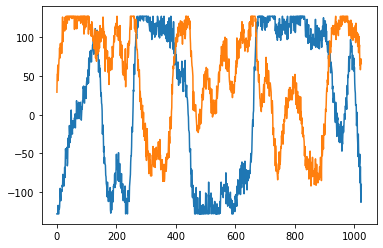

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

# Inspect a frame
mod = 12 # 0 to 26
snr_idx = 12 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = num_snrs*4096*mod + 4096*snr_idx + sample
data, mod, snr = data_h5[idx], label_mod[idx], label_snr[idx]
plt.figure()
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Input quantization
Quantize input data on-the-fly in software before feeding it to the accelerator. Use the uniform quantization range on which the model was trained.

In [10]:
def quantize(data):
    # quant_min = -128.0
    # quant_max = 127
    # quant_range = quant_max - quant_min
    # data_quant = (data - quant_min) / quant_range
    # data_quant = np.round(data_quant * 256) - 128
    # data_quant = np.clip(data_quant, -128, 127)
    data_quant=data
    data_quant = data_quant.astype(np.int8)
    return data_quant

# Classify a single frame

In [11]:
accel_in = quantize(data).reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 1024, 1, 2) and datatype is int8


In [12]:
accel_out = accel.execute(accel_in)

In [13]:
print("Result: " + str(accel_out))
print("Top-1 class predicted by the accelerator: " + mod_classes[int(accel_out)])

Result: [[12.]]
Top-1 class predicted by the accelerator: FM


In [14]:
%%timeit
accel_out = accel.execute(accel_in)

1.52 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Validate accuracy on entire test set

In [15]:
batch_size = 1024
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_folded()), str(accel.oshape_folded())))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_normal()), str(accel.oshape_normal())))

Accelerator buffer shapes are (1024, 1024, 1, 1, 2) for input, (1024, 1, 1) for output
Accelerator buffer shapes are (1024, 1024, 1, 1, 2) for input, (1024, 1, 1) for output
Accelerator buffer shapes are (1024, 1024, 1, 2) for input, (1024, 1) for output


In [16]:
import time
ok = 0
nok = 0
total = len(test_indices)
timer=0
for i_batch in range(math.ceil(total/batch_size)):
    i_frame = i_batch*batch_size
    if i_frame+batch_size > total:
        batch_size = total - i_frame
        accel.batch_size = batch_size
    batch_indices = test_indices[i_frame:i_frame+batch_size]
    data, mod, snr = data_h5[batch_indices], label_mod[batch_indices], label_snr[batch_indices]
    
    ibuf = quantize(data).reshape(accel.ishape_normal())
    
    start_time=time.time()
    obuf = accel.execute(ibuf)
    batch_time=time.time()-start_time
    timer+=batch_time
    
    pred = obuf.reshape(batch_size).astype(int)

    ok += np.equal(pred, mod).sum().item()
    nok += np.not_equal(pred, mod).sum().item()
    
    print("batch %d : total OK %d | NOK %d | Time: %.2f seconds" % (i_batch, ok, nok, batch_time))
    
print('total time: ',timer,' seconds')

batch 0 : total OK 896 | NOK 128 | Time: 0.42 seconds
batch 1 : total OK 1889 | NOK 159 | Time: 0.42 seconds
batch 2 : total OK 2911 | NOK 161 | Time: 0.42 seconds
batch 3 : total OK 3935 | NOK 161 | Time: 0.42 seconds
batch 4 : total OK 4959 | NOK 161 | Time: 0.42 seconds
batch 5 : total OK 5983 | NOK 161 | Time: 0.42 seconds
batch 6 : total OK 6700 | NOK 468 | Time: 0.42 seconds
batch 7 : total OK 7403 | NOK 789 | Time: 0.42 seconds
batch 8 : total OK 8270 | NOK 946 | Time: 0.42 seconds
batch 9 : total OK 9219 | NOK 1021 | Time: 0.42 seconds
batch 10 : total OK 10219 | NOK 1045 | Time: 0.42 seconds
batch 11 : total OK 11232 | NOK 1056 | Time: 0.42 seconds
batch 12 : total OK 12109 | NOK 1203 | Time: 0.42 seconds
batch 13 : total OK 12627 | NOK 1709 | Time: 0.42 seconds
batch 14 : total OK 13413 | NOK 1947 | Time: 0.42 seconds
batch 15 : total OK 14362 | NOK 2022 | Time: 0.42 seconds
batch 16 : total OK 15353 | NOK 2055 | Time: 0.42 seconds
batch 17 : total OK 16351 | NOK 2081 | Time:

In [17]:
acc = 100.0 * ok / (total)
print("Overall top-1 accuracy: {}%".format(acc))

Overall top-1 accuracy: 58.886178861788615%


## More benchmarking

In [18]:
accel.batch_size = 1024
accel.throughput_test()

{'runtime[ms]': 420.3016757965088,
 'throughput[images/s]': 2436.345270476092,
 'DRAM_in_bandwidth[MB/s]': 4.989635113935036,
 'DRAM_out_bandwidth[MB/s]': 0.002436345270476092,
 'fclk[mhz]': 249.9975,
 'batch_size': 1024,
 'fold_input[ms]': 0.09059906005859375,
 'pack_input[ms]': 0.06866455078125,
 'copy_input_data_to_device[ms]': 2.5734901428222656,
 'copy_output_data_from_device[ms]': 0.13136863708496094,
 'unpack_output[ms]': 0.5173683166503906,
 'unfold_output[ms]': 0.06318092346191406}